# Représentation graphique de l'effet du changement de règle de décision

L'objectif est de visualiser l'impact de chaque nouvelle règle de décision sur chaque groupe (DLP et seuillage VS classifieur de Bayes)

Cela permet notamment de vérifier si la condition "Do no Harm" est vérifiée pour chaque classifieur implémentant des contraintes de fairness.

In [12]:
# On place l'exécution du code à la racine du projet.
import sys
from pathlib import Path

root_path = Path().resolve().parent  
sys.path.append(str(root_path))

In [13]:
import pandas as pd
from data.preprocessing import prepare_data

X_train, X_test, y_train, y_test, protected_train, protected_test = prepare_data()

### Régression logistique standard

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

### DLP avec Fairlearn

In [ ]:
from fairlearn.reductions import ExponentiatedGradient,DemographicParity

constraint = DemographicParity()

clf_fair = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=constraint,
    eps=0.02  # tolérance fairness (à explorer)
)

clf_fair.fit(
    X_train,
    y_train,
    sensitive_features=protected_train
)

y_pred_fair = clf_fair.predict(X_test)

### Treatment disparity par seuillage

In [15]:
from fairness.treatment_disparity import MulticlassThresholdOptimizer

best_fair_clf = MulticlassThresholdOptimizer(protected_test)

opti_y_pred = best_fair_clf.fit_transform(X_train,y_train,X_test,gamma=0.001)

## Graphiques comparant les conflits intra-groupes

On récupère les probabilités de prédire 1 pour chaque classifieur

In [5]:
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred_fair_prob = clf_fair._pmf_predict(X_test)[:,1]

On entraîne une régression pour obtenir les probabilités de "ressembler à une personne blanche" selon les attributs du dataset

In [6]:
race_clf = LogisticRegression(max_iter=1000)

y_white = (protected_train == 'White').astype(int)

race_clf.fit(X_train,y_white)
white_proba = race_clf.predict_proba(X_test)[:,1]

On calcule ensuite les individus avantagés/désavantagés par la nouvelle règle de décision et on trace des graphiques pour le visualiser

### 1. Non-contraint VS DLP

In [7]:
df_viz = pd.DataFrame({
    'race': protected_test.reset_index(drop=True),
    'p_unconstrained': y_pred_prob,       # clf.predict_proba(X_test)[:,1]
    'p_fair': y_pred_fair_prob,          # fairlearn predict_proba[:,1]
    'p_white': white_proba 
})

threshold = 0.5

# effet individuel
def effect(row):
    if row['p_unconstrained'] < threshold <= row['p_fair']:
        return 'admitted because of treatment'
    elif row['p_unconstrained'] >= threshold > row['p_fair']:
        return 'rejected because of treatment'
    else:
        return 'unchanged'

df_viz['effect'] = df_viz.apply(effect, axis=1)

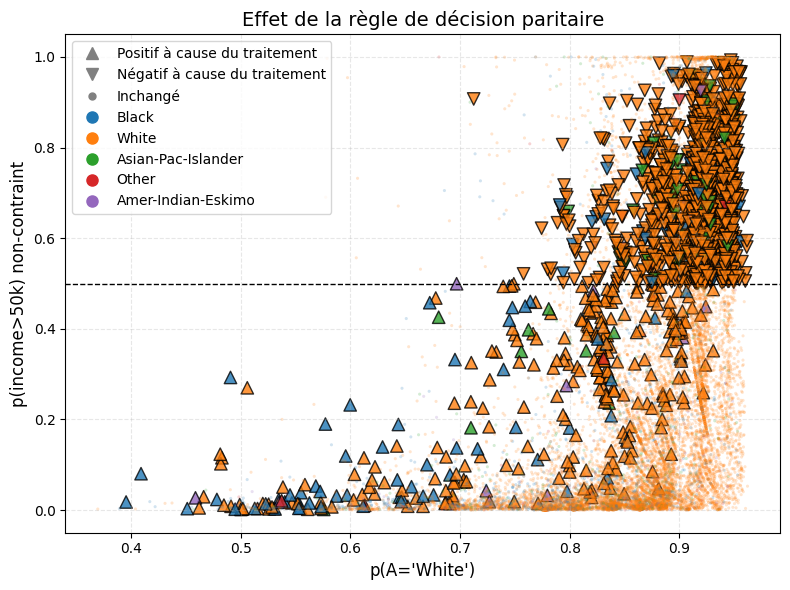

In [16]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

races = df_viz['race'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz[df_viz['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],
        subset['p_unconstrained'],
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel("p(A='White')", fontsize=12)
plt.ylabel('p(income>50k) non-contraint', fontsize=12)
plt.title('Effet de la règle de décision paritaire', fontsize=14)

legend_elements = []
# triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Positif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Négatif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Inchangé'))
# couleurs
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='upper left', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


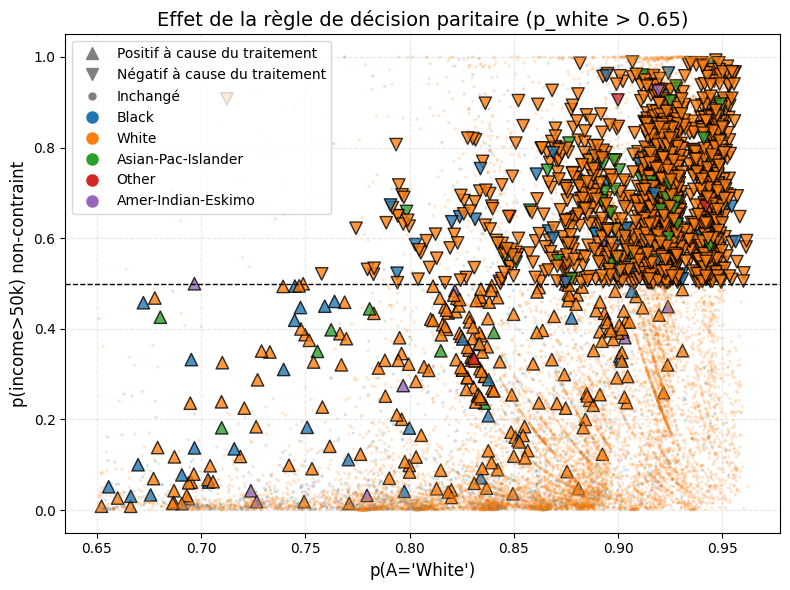

In [ ]:
# Filtrer les individus avec p_white > 0.65
df_viz_zoom = df_viz[df_viz['p_white'] > 0.65]

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

# Couleurs sobres par race
races = df_viz_zoom['race'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz_zoom[df_viz_zoom['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],
        subset['p_unconstrained'],
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel("p(A='White')", fontsize=12)
plt.ylabel('p(income>50k) non-contraint', fontsize=12)
plt.title('Effet de la règle de décision paritaire (p_white > 0.65)', fontsize=14)

legend_elements = []
# triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Positif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Négatif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Inchangé'))
# Couleurs
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


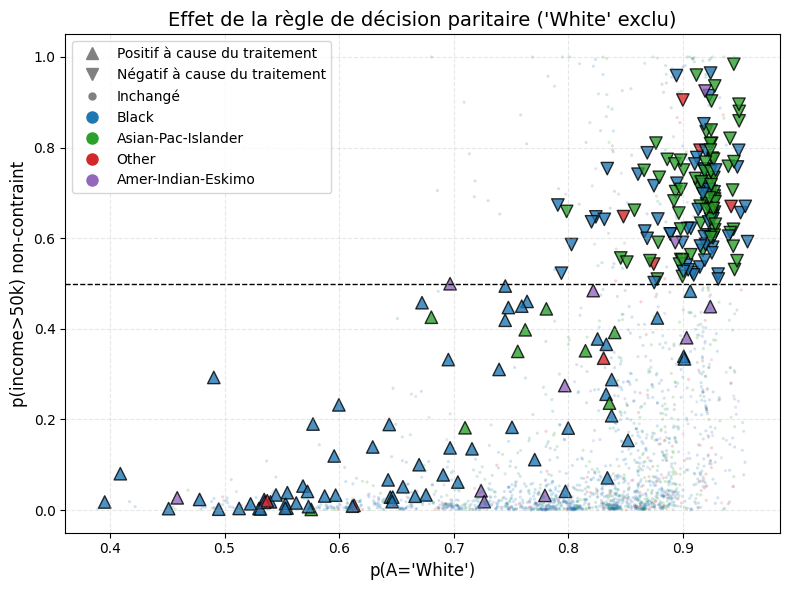

In [ ]:
# Filtrer les individus qui ne sont pas White
df_viz_nonwhite = df_viz[df_viz['race'] != 'White']

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

# Couleurs sobres par race
races = df_viz_nonwhite['race'].unique()
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']  # exclu le bleu utilisé pour White
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz_nonwhite[df_viz_nonwhite['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],                  # axe X = probabilité de ressembler à White
        subset['p_unconstrained'],          # axe Y = probabilité revenu>50k unconstrained
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel("p(A='White')", fontsize=12)
plt.ylabel('p(income>50k) non-contraint', fontsize=12)
plt.title("Effet de la règle de décision paritaire ('White' exclu)", fontsize=14)

legend_elements = []
# triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Positif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Négatif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Inchangé'))
# Couleurs par race (non-White)
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_760574/1892855317.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_viz_nonwhite= df_viz_nonwhite[df_viz['p_white'] > 0.65]


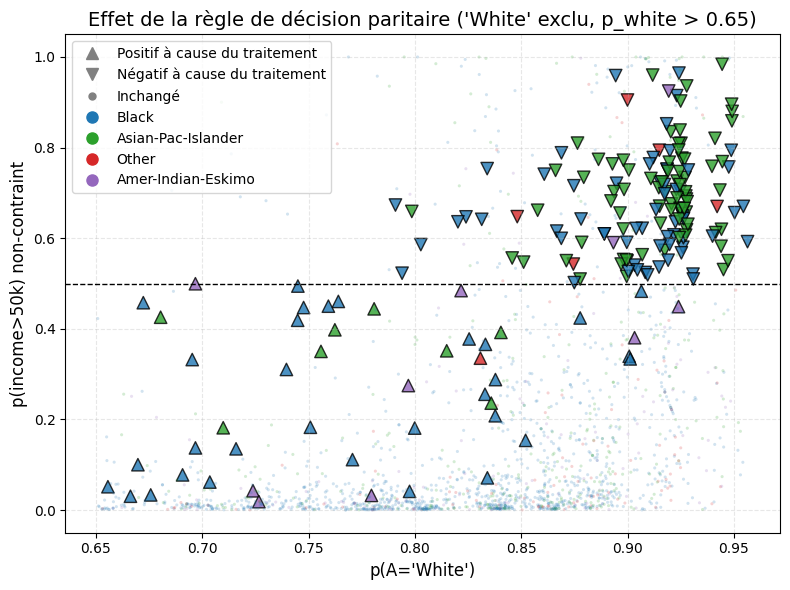

In [ ]:
# Filtrer les individus qui ne sont pas White + zoom
df_viz_nonwhite = df_viz[df_viz['race'] != 'White']
df_viz_nonwhite= df_viz_nonwhite[df_viz['p_white'] > 0.65]

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

# Couleurs sobres par race
races = df_viz_nonwhite['race'].unique()
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']  # exclu le orange utilisé pour White
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz_nonwhite[df_viz_nonwhite['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],                  # axe X = probabilité de ressembler à White
        subset['p_unconstrained'],          # axe Y = probabilité revenu>50k unconstrained
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel("p(A='White')", fontsize=12)
plt.ylabel('p(income>50k) non-contraint', fontsize=12)
plt.title("Effet de la règle de décision paritaire ('White' exclu, p_white > 0.65)", fontsize=14)

legend_elements = []
# triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Positif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Négatif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Inchangé'))
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

### 2. Non-contraint VS treatment disparity

In [19]:
df_viz_opti = pd.DataFrame({
    'race': protected_test.reset_index(drop=True),
    'p_unconstrained': y_pred_prob,       # clf.predict_proba(X_test)[:,1]
    'p_fair': opti_y_pred,          # fairlearn predict_proba[:,1]
    'p_white': white_proba 
})

threshold = 0.5

# effet individuel
def effect(row):
    if row['p_unconstrained'] < threshold <= row['p_fair']:
        return 'admitted because of treatment'
    elif row['p_unconstrained'] >= threshold > row['p_fair']:
        return 'rejected because of treatment'
    else:
        return 'unchanged'

df_viz_opti['effect'] = df_viz_opti.apply(effect, axis=1)

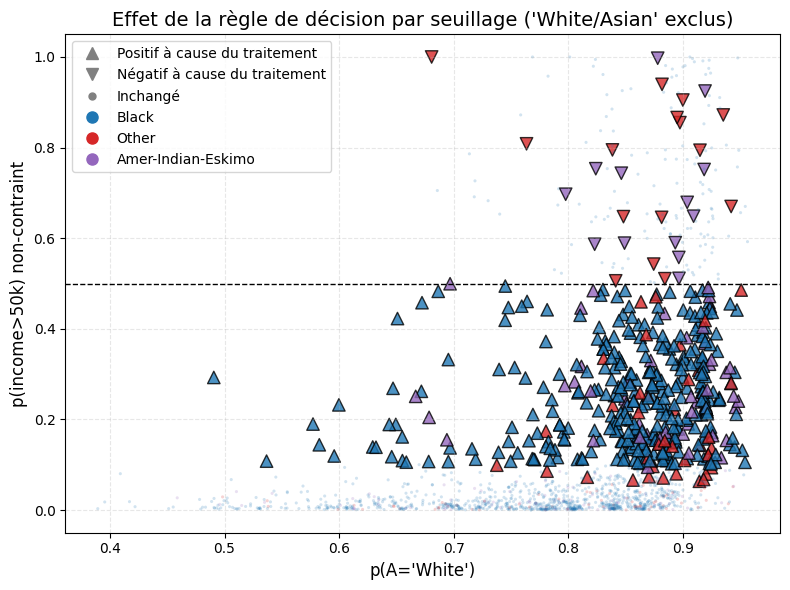

In [21]:
# Filtrer les individus qui ne sont pas White ou Asian
df_viz_nonwhite = df_viz_opti[df_viz_opti['race'] != 'White']
df_viz_nonwhite = df_viz_nonwhite[df_viz_nonwhite['race'] != 'Asian-Pac-Islander']

marker_map = {
    'admitted because of treatment': '^',
    'rejected because of treatment': 'v',
    'unchanged': 'o'
}

# Couleurs sobres par race
races = df_viz_nonwhite['race'].unique()
colors = ['#1f77b4','#d62728', '#9467bd']  # exclu le bleu utilisé pour White
color_map = dict(zip(races, colors))

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.set_facecolor('white')
ax.grid(True, linestyle='--', alpha=0.3)

for effect_type in ['admitted because of treatment', 'rejected because of treatment', 'unchanged']:
    subset = df_viz_nonwhite[df_viz_nonwhite['effect'] == effect_type]
    size = 80 if effect_type != 'unchanged' else 5
    alpha = 0.8 if effect_type != 'unchanged' else 0.2
    edgecolor = 'k' if effect_type != 'unchanged' else 'none'
    
    plt.scatter(
        subset['p_white'],                  # axe X = probabilité de ressembler à White
        subset['p_unconstrained'],          # axe Y = probabilité revenu>50k unconstrained
        marker=marker_map[effect_type],
        color=[color_map[r] for r in subset['race']],
        s=size,
        edgecolor=edgecolor,
        alpha=alpha
    )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)

plt.xlabel("p(A='White')", fontsize=12)
plt.ylabel('p(income>50k) non-contraint', fontsize=12)
plt.title("Effet de la règle de décision par seuillage ('White/Asian' exclus)", fontsize=14)

legend_elements = []
# triangles
legend_elements.append(mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label='Positif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label='Négatif à cause du traitement'))
legend_elements.append(mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=5, label='Inchangé'))
# Couleurs par race (non-White)
for race, color in color_map.items():
    legend_elements.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=race))

plt.legend(handles=legend_elements, loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()
